/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=1.
  warn(msg, IDWarning)
/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=2.
  warn(msg, IDWarning)
/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=3.
  warn(msg, IDWarning)
/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another Surface instance alr

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/harriet/anaconda3/envs/openmc-env/lib/python3.12/site-packages/openmc/mixin.py:70: IDWarning: Another PlotBase instance already exists with id=1.
  warn(msg, IDWarning)


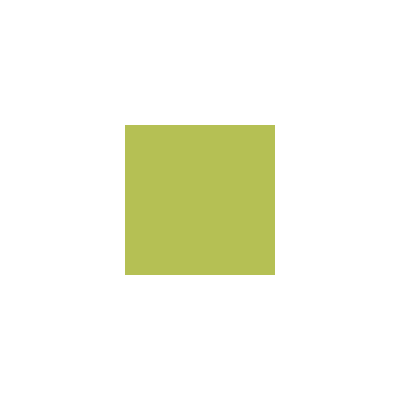

Tally
	ID             =	1
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength
	Multiply dens. =	True


'\n\n\n# Extract results\n#results_transmitted = output.get_tally(name=\'transmitted\')\n\n# Plot the geometry\nopenmc.plot_geometry(geom)\n#openmc.plot_geometry(geom, filename=\'geometry_plot.png\')\nplt.show()\n\n\n# Print results\n#print("Number of neutrons transmitted through water:", results_transmitted.mean)\n'

In [71]:

import openmc
import numpy as np
import openmc.data
import matplotlib.pyplot as plt


import os

os.environ["OPENMC_CROSS_SECTIONS"] = "/home/harriet/OPENMC/mcnp_endfb70/cross_sections.xml"


###############################################################################
#                      Simulation Input File Parameters
###############################################################################

# OpenMC simulation parameters
batches = 30
inactive = 10
particles = 100

###############################################################################
#                 Exporting to OpenMC materials.xml file
###############################################################################

# Create materials
rock = openmc.Material(material_id=1, name='Rock')
rock.add_element('Si', 0.277)
rock.add_nuclide('O16', 0.622)
rock.add_element('Al', 0.101)
rock.add_element('Fe',1.0)

rock.set_density('g/cm3', 2.65)


water = openmc.Material(material_id=2,name='Water')
water.add_element('H', 2)
water.add_nuclide('O16', 1)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

# Instantiate a Materials collection and export to XML
materials_file = openmc.Materials([water, rock])
materials_file.export_to_xml()

###############################################################################
#                 Exporting to OpenMC geometry.xml file
###############################################################################


# Create surfaces
wall_thickness = 0.5
water_thickness = 0.5
wall_length= 1.5
water_length= 1.5



# Create surfaces for rock wall
left_surface_rock = openmc.XPlane(surface_id=1,x0=-wall_length/2, boundary_type='reflective')
right_surface_rock = openmc.XPlane(surface_id=2,x0=wall_length/2, boundary_type='reflective')
bottom_surface_rock = openmc.YPlane(surface_id=3,y0=-wall_length/2, boundary_type='reflective')
top_surface_rock = openmc.YPlane(surface_id=4,y0=wall_length/2, boundary_type='reflective')
front_surface_rock = openmc.ZPlane(surface_id=5,z0=-wall_thickness/2, boundary_type='reflective')
back_surface_rock = openmc.ZPlane(surface_id=6,z0=wall_thickness/2, boundary_type='reflective')

# Create surfaces for water wall
left_surface_water = openmc.XPlane(surface_id=7,x0=-water_length/2, boundary_type='reflective')
right_surface_water = openmc.XPlane(surface_id=8,x0=water_length/2, boundary_type='reflective')
bottom_surface_water = openmc.YPlane(surface_id=9,y0=-water_length/2, boundary_type='reflective')
top_surface_water = openmc.YPlane(surface_id=10,y0=water_length/2, boundary_type='reflective')
front_surface_water = openmc.ZPlane(surface_id=11,z0=-water_thickness/2, boundary_type='reflective')
back_surface_water = openmc.ZPlane(surface_id=12,z0=water_thickness/2, boundary_type='reflective')

# Instantiate Cells_for rock wall and water wall. 
cell1 = openmc.Cell(cell_id=1, name='Cell 1')
cell2 = openmc.Cell(cell_id=2, name='Cell 2')
cell1.region = +left_surface_rock & -right_surface_rock & +bottom_surface_rock & -top_surface_rock & +front_surface_rock & -back_surface_rock 
cell2.region = +left_surface_water & -right_surface_water & +bottom_surface_water & -top_surface_water & +front_surface_water & -back_surface_water 
# Register Materials with Cells
cell1.fill = rock
cell2.fill = water
# Create universe
root = openmc.Universe(universe_id=0, name='root universe')
root.add_cell(cell1)
root.add_cell(cell2)
# Instantiate a Geometry, register the root Universe, and export to XML
geometry = openmc.Geometry(root)
geometry.export_to_xml()




###############################################################################
#                   Exporting to OpenMC settings.xml file
###############################################################################

# Create settings
settings = openmc.Settings()
settings.run_mode = 'fixed source'
settings.particles = particles
settings.batches = batches
settings.inactive = inactive
# Define energy distribution
energy = openmc.stats.Discrete([14e6], [1.0])  # Single energy of 14 MeV

source = openmc.IndependentSource(space=openmc.stats.Point(), energy=energy)
settings.source = source

# Export to "settings.xml"
settings.export_to_xml()

###############################################################################
#                   Exporting to OpenMC tallies.xml file
###############################################################################
# Instantiate an empty Tallies object
tallies = openmc.Tallies()

# Create mesh which will be used for tally
mesh = openmc.RegularMesh()
mesh.dimension = [100, 100, ]
mesh.lower_left = [-1.5, -1.5]
mesh.upper_right = [1.5, 1.5]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)
# Create mesh tally to score flux and fission rate
tally = openmc.Tally(tally_id=1,name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux', 'fission']
tallies.append(tally)
# Export to "tallies.xml"
tallies.export_to_xml()



# Create a simulation model
model = openmc.Model(geometry=geometry, settings=settings, tallies= tallies)

# Run the simulation
output = openmc.run()

###############################################################################
#                   Exporting to OpenMC plots.xml file
###############################################################################

plot = openmc.Plot(plot_id=1)
plot.origin = [0, 0, 0]
plot.width = [4, 4]
plot.pixels = [400, 400]
plot.color_by = 'material'

# Instantiate a Plots collection and export to XML
plot_file = openmc.Plots([plot])
plot.geometry=geometry
openmc.plot_inline(plot)
plot_file.export_to_xml()

# Load the statepoint file
sp = openmc.StatePoint('statepoint.30.h5')
tally = sp.get_tally(scores=['flux'])
print(tally)
tally.sum




'''
vox_plot = openmc.Plot(plot_id=2)
vox_plot.type = 'voxel'
vox_plot.width = [100., 100.,50.]
vox_plot.pixels = [400, 400,200]
vox_plot.color_by = 'material'

# Instantiate a Plots collection and export to XML
vox_plot = openmc.Plots([vox_plot])
vox_plot.geometry=geometry
openmc.vox_plot(vox_plot)

'''
'''


# Extract results
#results_transmitted = output.get_tally(name='transmitted')

# Plot the geometry
openmc.plot_geometry(geom)
#openmc.plot_geometry(geom, filename='geometry_plot.png')
plt.show()


# Print results
#print("Number of neutrons transmitted through water:", results_transmitted.mean)
'''
